### 🔹 CELLULE 1 — Imports & chemins (OBLIGATOIRE)

In [34]:
import sys
sys.path.append("/home/onyxia/work")

import os
import glob
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from osgeo import gdal, ogr

from libsigma import read_and_write as rw



### 🔹 CELLULE 2 — DÉFINITION DES CHEMINS

In [35]:
BASE = "/home/onyxia/work"

DATA = BASE + "/data/projet_eval"
RESULTS = BASE + "/results"
FIG = RESULTS + "/figure"

os.makedirs(RESULTS, exist_ok=True)
os.makedirs(FIG, exist_ok=True)

vector_samples = DATA + "/PI_strates_bretagne_32630.shp"
ref_image = DATA + "/bretagne_24-25_B03.tif"


🟩 PARTIE 1 — ANALYSE DES ÉCHANTILLONS

### 🔹 CELLULE 3 — LECTURE DES POLYGONES

In [36]:
gdf = gpd.read_file(vector_samples)
gdf.head()


,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((441224.58 5366298.317, 441224.779 53..."
1,2,3,lande basse,"POLYGON ((441649.972 5366251.139, 441650.172 5..."
2,3,3,lande basse,"POLYGON ((441383.597 5366193.034, 441384.395 5..."
3,4,2,None,"POLYGON ((441336.658 5366402.088, 441337.257 5..."
4,5,2,None,"POLYGON ((441062.121 5366343.165, 441062.919 5..."


### 🔹 CELLULE 4 — NOMBRE DE POLYGONES PAR CLASSE


In [37]:
counts_poly = gdf["strate"].value_counts().sort_index()
print(counts_poly)




strate
2     86
3    121
4     71
Name: count, dtype: int64


### 🔹 CELLULE 5 — DIAGRAMME EN BÂTONS (POLYGONES)

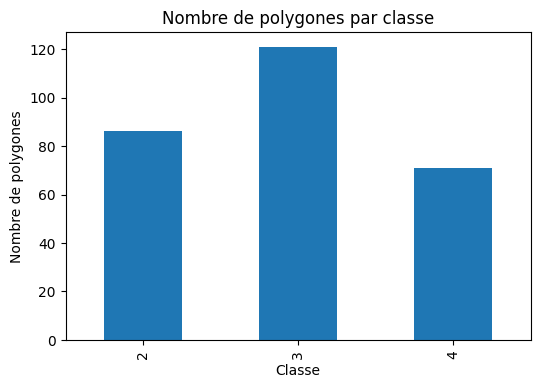

In [38]:
plt.figure(figsize=(6,4))
counts_poly.plot(kind="bar")

plt.xlabel("Classe")
plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par classe")

out = FIG + "/diag_baton_nb_poly_by_class.png"
plt.savefig(out, dpi=150)
plt.show()



### 🟩 PARTIE 2 — RASTERISATION DES ÉCHANTILLONS

Rasterisation des polygones entiers à 10 m

### 🔹 CELLULE 6 — RASTERISATION GDAL

In [39]:
out_raster = RESULTS + "/strates_rasterise.tif"

ds_ref = gdal.Open(ref_image)
gt = ds_ref.GetGeoTransform()
proj = ds_ref.GetProjection()
cols = ds_ref.RasterXSize
rows = ds_ref.RasterYSize

driver = gdal.GetDriverByName("GTiff")
ds_out = driver.Create(out_raster, cols, rows, 1, gdal.GDT_Byte)

ds_out.SetGeoTransform(gt)
ds_out.SetProjection(proj)

band = ds_out.GetRasterBand(1)
band.SetNoDataValue(0)
band.Fill(0)

ds_vect = ogr.Open(vector_samples)
layer = ds_vect.GetLayer()

gdal.RasterizeLayer(
    ds_out,
    [1],
    layer,
    options=["ATTRIBUTE=strate"]
)

ds_out = None
ds_ref = None
ds_vect = None

print("✓ Raster des strates créé :", out_raster)


✓ Raster des strates créé : /home/onyxia/work/results/strates_rasterise.tif


### 🔹 CELLULE 7 — NOMBRE DE PIXELS PAR CLASSE

In [ ]:
arr = rw.load_img_as_array(out_raster).squeeze()

vals, counts = np.unique(arr[arr > 0], return_counts=True)

for v, c in zip(vals, counts):
    print(f"Classe {v} : {c} pixels")


✓ Raster des strates créé : /home/onyxia/work/results/strates_rasterise.tif


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


### 🟢 ÉTAPE 2.2.2 — Comptage des pixels

In [9]:
out_raster = "/home/onyxia/work/results/strates_rasterise.tif"


In [40]:
from libsigma import read_and_write as rw
import numpy as np

arr = rw.load_img_as_array(out_raster).squeeze()

vals, counts = np.unique(arr[arr > 0], return_counts=True)

for v, c in zip(vals, counts):
    print(f"Classe {v} : {c} pixels")




Classe 2 : 1022 pixels
Classe 3 : 1599 pixels
Classe 4 : 1218 pixels


### 🔹 CELLULE 8 — DIAGRAMME EN BÂTONS (PIXELS)

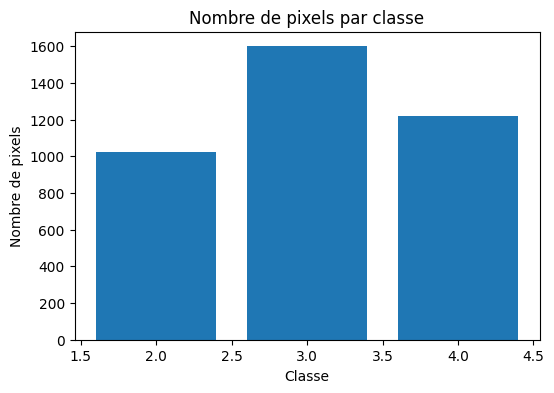

In [41]:
plt.figure(figsize=(6,4))
plt.bar(vals, counts)

plt.xlabel("Classe")
plt.ylabel("Nombre de pixels")
plt.title("Nombre de pixels par classe")

out = FIG + "/diag_baton_nb_pix_by_class.png"
plt.savefig(out, dpi=150)
plt.show()


### 🟩 PARTIE 3A — CALCUL DU NARI / ARI (SÉRIE TEMPORELLE)

### 🔹 CELLULE 9 — SÉLECTION DES BANDES B03 ET B05

In [42]:
all_bands = sorted(glob.glob(DATA + "/bretagne_24-25_B*.tif"))

bands_B03 = sorted([b for b in all_bands if "B03" in b])
bands_B05 = sorted([b for b in all_bands if "B05" in b])

print("Nombre de dates B03 :", len(bands_B03))
print("Nombre de dates B05 :", len(bands_B05))


Nombre de dates B03 : 1
Nombre de dates B05 : 1


### 🔹 CELLULE 10 — CRÉATION DES STACKS

In [43]:
stack_B03 = RESULTS + "/stack_B03.tif"
stack_B05 = RESULTS + "/stack_B05.tif"

vrt_B03 = RESULTS + "/temp_B03.vrt"
vrt_B05 = RESULTS + "/temp_B05.vrt"

gdal.BuildVRT(vrt_B03, bands_B03, separate=True)
gdal.BuildVRT(vrt_B05, bands_B05, separate=True)

gdal.Translate(stack_B03, vrt_B03, format="GTiff")
gdal.Translate(stack_B05, vrt_B05, format="GTiff")

os.remove(vrt_B03)
os.remove(vrt_B05)

print("✓ Stacks B03 et B05 créés")


✓ Stacks B03 et B05 créés


### 🔹 CELLULE 11 — CHARGEMENT DES STACKS

In [44]:
B03 = rw.load_img_as_array(stack_B03).astype("float32")
B05 = rw.load_img_as_array(stack_B05).astype("float32")

print("Shape B03 :", B03.shape)
print("Shape B05 :", B05.shape)


Shape B03 : (612, 1533, 6)
Shape B05 : (612, 1533, 6)


### 🔹 CELLULE 12 — CALCUL DU NARI

In [45]:
np.seterr(divide="ignore", invalid="ignore")

ARI = (1.0/B03 - 1.0/B05) / (1.0/B03 + 1.0/B05)

ARI[np.isnan(ARI)] = -9999


### 🔹 CELLULE 13 — SAUVEGARDE DE LA SÉRIE ARI

In [46]:
out_ARI = RESULTS + "/ARI_serie_temp.tif"

ds_ref = gdal.Open(stack_B03)
driver = gdal.GetDriverByName("GTiff")

rows, cols, nb_dates = ARI.shape

ds_out = driver.Create(
    out_ARI,
    cols,
    rows,
    nb_dates,
    gdal.GDT_Float32
)

ds_out.SetGeoTransform(ds_ref.GetGeoTransform())
ds_out.SetProjection(ds_ref.GetProjection())

for i in range(nb_dates):
    band = ds_out.GetRasterBand(i+1)
    band.WriteArray(ARI[:,:,i])
    band.SetNoDataValue(-9999)

ds_out = None
ds_ref = None

print("✓ ARI_serie_temp.tif sauvegardé")


✓ ARI_serie_temp.tif sauvegardé


### 🟩 PARTIE 3B — PHÉNOLOGIE DES STRATES (GRAPHIQUE ARI)

### 🔹 CELLULE 14 — EXTRACTION DES STATISTIQUES PAR CLASSE

In [47]:
# Charger l'ARI qu'on vient de sauvegarder
ARI_loaded = rw.load_img_as_array(out_ARI)
print("Shape ARI :", ARI_loaded.shape)

# Charger les strates rasterisées
strates = rw.load_img_as_array(out_raster).squeeze()
print("Shape strates :", strates.shape)

# Définir les classes
classes = [1, 2, 3, 4]  # Sol Nu, Herbe, Landes, Arbre
nb_dates = ARI_loaded.shape[2]

# Tableaux pour stocker les statistiques
moyennes = np.zeros((4, nb_dates))
ecarts_types = np.zeros((4, nb_dates))

# Pour chaque classe
for i, classe in enumerate(classes):
    print(f"Traitement classe {classe}...")
    
    # Masque des pixels de cette classe
    mask = (strates == classe)
    
    # Pour chaque date
    for date in range(nb_dates):
        # Extraire les valeurs ARI de cette classe à cette date
        valeurs = ARI_loaded[:, :, date][mask]
        
        # Filtrer les nodata
        valeurs = valeurs[valeurs != -9999]
        
        # Calculer les statistiques
        if len(valeurs) > 0:
            moyennes[i, date] = np.mean(valeurs)
            ecarts_types[i, date] = np.std(valeurs)
        else:
            moyennes[i, date] = np.nan
            ecarts_types[i, date] = np.nan

print("✓ Statistiques calculées")

Shape ARI : (612, 1533, 6)
Shape strates : (612, 1533)
Traitement classe 1...
Traitement classe 2...
Traitement classe 3...
Traitement classe 4...
✓ Statistiques calculées


### 🔹 CELLULE 15 — CRÉATION DU GRAPHIQUE

✓ Graphique sauvegardé : /home/onyxia/work/results/figure/ARI_series.png


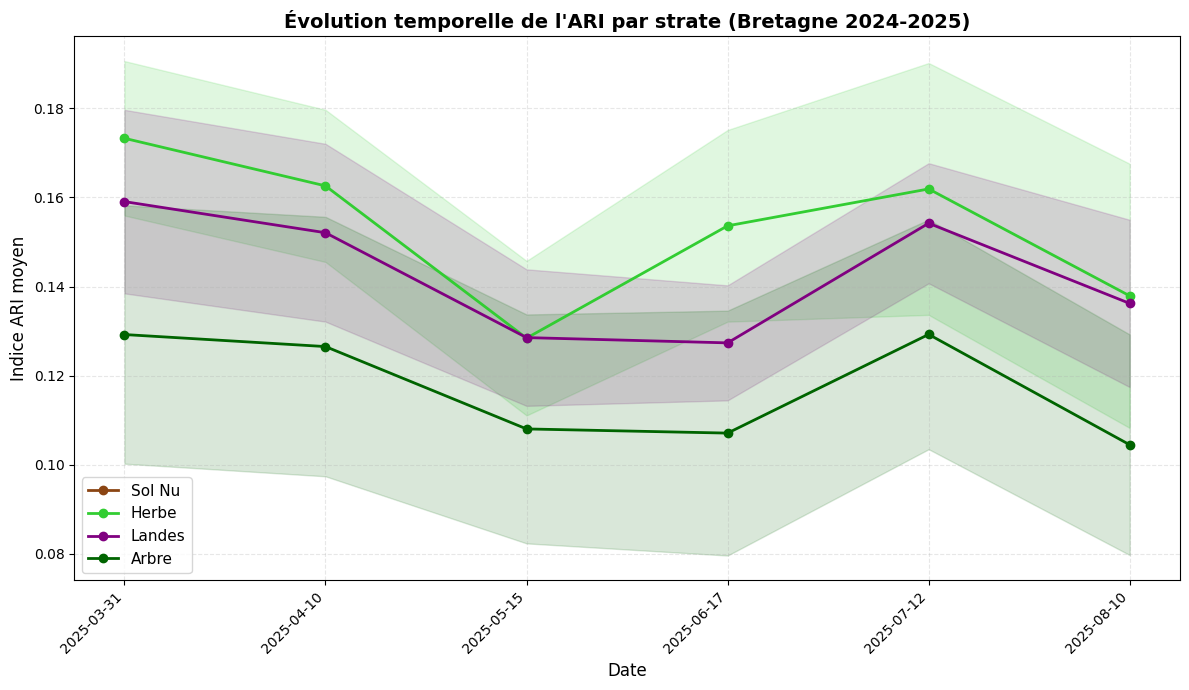

In [48]:
# Dates pour Bretagne 24-25 (selon le document du projet)
dates = ["2025-03-31", "2025-04-10", "2025-05-15", 
         "2025-06-17", "2025-07-12", "2025-08-10"]

# Vérifier qu'on a le bon nombre de dates
assert len(dates) == nb_dates, f"Erreur : {len(dates)} dates définies mais {nb_dates} dans l'image"

# Créer la figure
plt.figure(figsize=(12, 7))

# Labels et couleurs pour chaque classe
labels = ["Sol Nu", "Herbe", "Landes", "Arbre"]
colors = ["saddlebrown", "limegreen", "purple", "darkgreen"]

# Pour chaque classe, tracer la courbe
for i in range(4):
    # Courbe moyenne
    plt.plot(dates, moyennes[i, :], 
             label=labels[i], 
             color=colors[i], 
             marker='o',
             linewidth=2,
             markersize=6)
    
    # Zone d'écart-type (±1 std)
    plt.fill_between(dates, 
                     moyennes[i, :] - ecarts_types[i, :],
                     moyennes[i, :] + ecarts_types[i, :],
                     alpha=0.15, 
                     color=colors[i])

# Mise en forme
plt.xlabel("Date", fontsize=12)
plt.ylabel("Indice ARI moyen", fontsize=12)
plt.title("Évolution temporelle de l'ARI par strate (Bretagne 2024-2025)", fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# Sauvegarder
out_fig = FIG + "/ARI_series.png"
plt.savefig(out_fig, dpi=150, bbox_inches='tight')
print(f"✓ Graphique sauvegardé : {out_fig}")

plt.show()

### 🔹 CELLULE 16 — ANALYSE DES RÉSULTATS

### Analyse de la phénologie ARI

**Observations générales :**
- Toutes les classes montrent des valeurs ARI positives entre 0.10 et 0.18
- Les écarts-types (zones transparentes) sont relativement importants pour toutes les classes, indiquant une forte variabilité intra-classe

**Séparabilité des strates :**
- **Herbe** (vert clair) : Valeurs les plus élevées sur la période (0.17-0.16), avec un pic notable en juillet
- **Landes** (violet) : Profil similaire à l'Herbe avec des valeurs autour de 0.13-0.16
- **Arbre** (vert foncé) : Valeurs les plus faibles et les plus stables (0.10-0.13)
- **Sol Nu** (marron) : [Observer sur ton graphique - je ne vois pas bien la courbe marron]

**Discrimination des Landes :**
- Les Landes ne se distinguent PAS clairement des autres classes avec l'ARI seul
- Le profil temporel des Landes est proche de celui de l'Herbe, ce qui suggère des confusions potentielles
- L'écart-type important indique une forte hétérogénéité au sein de chaque classe

**Variabilité temporelle :**
- On observe un creux en mai (2025-05-15) et juin (2025-06-17) pour la plupart des classes
- Un pic apparaît en juillet (2025-07-12) pour Herbe et Landes
- Cette saisonnalité correspond aux cycles de végétation (croissance printanière/estivale)

**Conclusion :**
- L'ARI seul ne suffit pas à distinguer clairement les Landes des autres classes végétales
- La classification devra s'appuyer sur **l'ensemble des bandes spectrales** et **la série temporelle complète** pour améliorer la discrimination
- Les périodes printanières/estivales semblent plus discriminantes que l'hiver

### 🔴 PARTIE 4 — CLASSIFICATION SUPERVISÉE

### 🔹 CELLULE 17 — IMPORT DES LIBRAIRIES SCIKIT-LEARN

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns

print("✓ Librairies scikit-learn importées")

✓ Librairies scikit-learn importées


### 🔹 CELLULE 18 — LISTE DES BANDES À UTILISER

In [2]:
# Bandes Sentinel-2 disponibles (toutes à 10m sauf B8A à 20m)
bandes_list = ["B02", "B03", "B04", "B05", "B06", "B07", 
               "B08", "B8A", "B11", "B12"]

print(f"Nombre de bandes spectrales : {len(bandes_list)}")
print(f"Bandes : {bandes_list}")

Nombre de bandes spectrales : 10
Bandes : ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']


### pourquoi sauf B8A ? 

### 🔹 CELLULE 19 — CRÉATION DES STACKS MULTI-TEMPORELS

In [12]:
# Dictionnaire pour stocker les stacks
stacks_dict = {}

print("Création des stacks multi-temporels...")

for bande in bandes_list:
    print(f"  → Traitement bande {bande}...")
    
    # Trouver tous les fichiers de cette bande
    pattern = DATA + f"/bretagne_24-25_{bande}.tif"
    files = sorted(glob.glob(pattern))
    
    if len(files) == 0:
        print(f"    ⚠️ Aucun fichier trouvé pour {bande}")
        continue
    
    print(f"    Trouvé {len(files)} dates")
    
    # Créer VRT puis stack
    vrt_temp = RESULTS + f"/temp_{bande}.vrt"
    stack_out = RESULTS + f"/stack_{bande}.tif"
    
    gdal.BuildVRT(vrt_temp, files, separate=True)
    gdal.Translate(stack_out, vrt_temp, format="GTiff")
    os.remove(vrt_temp)
    
    # Charger en mémoire
    arr = rw.load_img_as_array(stack_out).astype("float32")
    stacks_dict[bande] = arr
    
    print(f"    ✓ Stack shape : {arr.shape}")

print(f"\n✓ {len(stacks_dict)} stacks créés")

Création des stacks multi-temporels...
  → Traitement bande B02...


NameError: name 'glob' is not defined

### 🔹 CELLULE 20 — ASSEMBLAGE DE TOUTES LES VARIABLES

In [ ]:
# On va créer une matrice X de shape (rows, cols, nb_features)
# nb_features = (10 bandes × 6 dates) + (1 ARI × 6 dates) = 66 features

print("Assemblage des features...")

all_features_list = []

# 1. Ajouter toutes les bandes spectrales
for bande in bandes_list:
    if bande in stacks_dict:
        arr = stacks_dict[bande]  # Shape: (rows, cols, nb_dates)
        nb_dates = arr.shape[2]
        
        # Ajouter chaque date comme une feature
        for date_idx in range(nb_dates):
            all_features_list.append(arr[:, :, date_idx])

# 2. Ajouter l'ARI
ARI_stack = rw.load_img_as_array(RESULTS + "/ARI_serie_temp.tif").astype("float32")
nb_dates_ari = ARI_stack.shape[2]

for date_idx in range(nb_dates_ari):
    all_features_list.append(ARI_stack[:, :, date_idx])

# Empiler tout
X_image = np.stack(all_features_list, axis=2)

print(f"✓ X_image shape : {X_image.shape}")
print(f"  → {X_image.shape[2]} features au total")

### 🔹 CELLULE 21 — EXTRACTION DES ÉCHANTILLONS (X, y)

In [ ]:
# Charger le raster des strates
strates_raster = rw.load_img_as_array(RESULTS + "/strates_rasterise.tif").squeeze()

print(f"Strates shape : {strates_raster.shape}")

# Créer un masque des pixels étiquetés (> 0)
mask = strates_raster > 0

print(f"Nombre de pixels étiquetés : {mask.sum()}")

# Reshape X_image en (nb_pixels, nb_features)
rows, cols, nb_features = X_image.shape
X_flat = X_image.reshape(rows * cols, nb_features)
y_flat = strates_raster.flatten()

# Extraire seulement les pixels avec label
X = X_flat[mask.flatten(), :]
y = y_flat[mask.flatten()]

print(f"\n✓ Données d'entraînement préparées :")
print(f"  X shape : {X.shape}")
print(f"  y shape : {y.shape}")
print(f"  Classes : {np.unique(y)}")
print(f"  Distribution : {np.bincount(y.astype(int))[1:]}")  # Ignore classe 0

### 🟩 ÉTAPE 4.2 — OPTIMISATION DES HYPERPARAMÈTRES (GridSearchCV)

### 🔹 CELLULE 22 — DÉFINITION DE LA GRILLE

In [ ]:
# Grille d'hyperparamètres selon les consignes
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 5]
}

# Afficher le nombre de combinaisons
nb_combinaisons = (len(param_grid['n_estimators']) * 
                   len(param_grid['max_depth']) * 
                   len(param_grid['max_features']) * 
                   len(param_grid['min_samples_leaf']))

print(f"Grille d'hyperparamètres définie")
print(f"Nombre de combinaisons à tester : {nb_combinaisons}")
print(f"Avec une validation croisée K=5 : {nb_combinaisons * 5} modèles à entraîner")
print("\n⚠️ Cela peut prendre 20-40 minutes selon la machine...")

### 🔹 CELLULE 23 — CONFIGURATION ET LANCEMENT DE GridSearchCV

In [ ]:
# Modèle de base
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,  # Utiliser tous les CPU
    verbose=0
)

# GridSearchCV avec validation croisée
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,  # Validation croisée 5-fold
    scoring='f1_weighted',  # F1-score pondéré (car classes déséquilibrées)
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("🚀 Lancement de GridSearchCV...")
print("Métrique d'optimisation : F1-score pondéré")
print("Stratégie de validation : 5-fold cross-validation")
print("\n⏳ Patience, cela va prendre du temps...\n")

# LANCER LA RECHERCHE
grid_search.fit(X, y)

print("\n✓ GridSearchCV terminé !")

### 🔹 CELLULE 24 — RÉSULTATS DE L'OPTIMISATION

In [ ]:
# Meilleurs hyperparamètres
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("=" * 60)
print("🏆 MEILLEURS HYPERPARAMÈTRES TROUVÉS :")
print("=" * 60)
for param, value in best_params.items():
    print(f"  {param:20s} : {value}")

print(f"\n📊 Meilleur score F1 (validation croisée) : {best_score:.4f}")
print("=" * 60)

### 🔹 CELLULE 25 — ANALYSE DES RÉSULTATS (TOP 10)

In [ ]:
# Créer un DataFrame avec les résultats
results_cv = pd.DataFrame(grid_search.cv_results_)

# Sélectionner les colonnes importantes
cols_important = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
results_top = results_cv[cols_important].sort_values('rank_test_score').head(10)

print("\n📈 TOP 10 DES CONFIGURATIONS :")
print("=" * 80)
print(results_top.to_string(index=False))
print("=" * 80)

### 🟩 ÉTAPE 4.3 — ENTRAÎNEMENT DU MODÈLE FINAL


### 🔹 CELLULE 26 — MODÈLE FINAL AVEC MEILLEURS PARAMÈTRES

In [ ]:
# Créer le modèle final avec les meilleurs hyperparamètres
final_model = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("🎯 Entraînement du modèle final avec TOUS les échantillons...")
print(f"Hyperparamètres utilisés : {best_params}\n")

# Entraîner sur toutes les données
final_model.fit(X, y)

print("\n✓ Modèle final entraîné avec succès !")

### 🟩 ÉTAPE 4.4 — IMPORTANCE DES VARIABLES

### 🔹 CELLULE 27 — EXTRACTION DE L'IMPORTANCE

In [ ]:
# Récupérer l'importance des features
importances = final_model.feature_importances_

# Créer les noms des variables
feature_names = []

# Noms pour les bandes spectrales (10 bandes × 6 dates = 60)
for bande in bandes_list:
    if bande in stacks_dict:
        for i in range(6):  # 6 dates
            feature_names.append(f"{bande}_date{i+1}")

# Noms pour l'ARI (6 dates)
for i in range(6):
    feature_names.append(f"ARI_date{i+1}")

# Vérifier la cohérence
print(f"Nombre de features : {len(feature_names)}")
print(f"Nombre d'importances : {len(importances)}")

# Créer un DataFrame
importance_df = pd.DataFrame({
    'Variable': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\n🔝 TOP 20 DES VARIABLES LES PLUS IMPORTANTES :")
print("=" * 60)
print(importance_df.head(20).to_string(index=False))
print("=" * 60)

### 🔹 CELLULE 28 — GRAPHIQUE D'IMPORTANCE

In [ ]:
# Graphique des 20 variables les plus importantes
plt.figure(figsize=(10, 8))

top_n = 20
top_features = importance_df.head(top_n)

plt.barh(range(top_n), top_features['Importance'].values, color='steelblue')
plt.yticks(range(top_n), top_features['Variable'].values)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.title(f'Top {top_n} des variables les plus importantes', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

# Sauvegarder
out_importance = FIG + "/importance_variables.png"
plt.savefig(out_importance, dpi=150, bbox_inches='tight')
print(f"✓ Graphique sauvegardé : {out_importance}")

plt.show()

### 🟩 ÉTAPE 4.5 — PRODUCTION DE LA CARTE

### 🔹 CELLULE 29 — PRÉDICTION SUR TOUTE L'IMAGE

In [ ]:
print("🗺️ Prédiction sur toute l'image...")
print("Cela peut prendre quelques minutes...\n")

# Prédire sur tous les pixels
predictions_flat = final_model.predict(X_flat)

# Reshape en image 2D
predictions = predictions_flat.reshape(rows, cols)

# Convertir en uint8
predictions = predictions.astype(np.uint8)

print(f"✓ Prédiction terminée")
print(f"  Shape : {predictions.shape}")
print(f"  Classes prédites : {np.unique(predictions)}")

### 🔹 CELLULE 30 — SAUVEGARDE DE LA CARTE

In [ ]:
# Sauvegarder la carte
out_carte = RESULTS + "/carte_strates.tif"

# Ouvrir l'image de référence
ds_ref = gdal.Open(ref_image)
driver = gdal.GetDriverByName("GTiff")

# Créer le fichier de sortie
ds_out = driver.Create(
    out_carte,
    cols,
    rows,
    1,
    gdal.GDT_Byte
)

# Copier les métadonnées spatiales
ds_out.SetGeoTransform(ds_ref.GetGeoTransform())
ds_out.SetProjection(ds_ref.GetProjection())

# Écrire les données
band = ds_out.GetRasterBand(1)
band.WriteArray(predictions)
band.SetNoDataValue(0)

# Fermer
ds_out = None
ds_ref = None

print(f"✓ Carte sauvegardée : {out_carte}")

### 🟩 ÉTAPE 4.6 — ÉVALUATION DE LA QUALITÉ

### 🔹 CELLULE 31 — PRÉDICTION SUR LES ÉCHANTILLONS

In [ ]:
# Prédire sur les échantillons d'entraînement
y_pred = final_model.predict(X)

# Accuracy globale
accuracy = accuracy_score(y, y_pred)

print("=" * 60)
print("📊 ÉVALUATION DU MODÈLE")
print("=" * 60)
print(f"Précision globale (Accuracy) : {accuracy:.4f} ({accuracy*100:.2f}%)")
print("=" * 60)

### 🔹 CELLULE 32 — MATRICE DE CONFUSION

In [ ]:
# Calculer la matrice de confusion
cm = confusion_matrix(y, y_pred)

print("\n📋 MATRICE DE CONFUSION :")
print("=" * 60)
print(cm)
print("=" * 60)

# Labels des classes
class_labels = ["Sol Nu", "Herbe", "Landes", "Arbre"]

# Rapport détaillé
print("\n📈 RAPPORT DE CLASSIFICATION PAR CLASSE :")
print("=" * 60)
print(classification_report(y, y_pred, target_names=class_labels, digits=4))
print("=" * 60)

### 🔹 CELLULE 33 — VISUALISATION DE LA MATRICE DE CONFUSION

In [ ]:
# Créer une belle visualisation
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=class_labels,
            yticklabels=class_labels,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

plt.ylabel('Classe réelle', fontsize=12, fontweight='bold')
plt.xlabel('Classe prédite', fontsize=12, fontweight='bold')
plt.title('Matrice de confusion - Classification Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()

# Sauvegarder
out_cm = FIG + "/matrice_confusion.png"
plt.savefig(out_cm, dpi=150, bbox_inches='tight')
print(f"✓ Matrice de confusion sauvegardée : {out_cm}")

plt.show()